In [1]:
# import general libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
# from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import fsolve

In [2]:
class DeterministicAgent():
    def __init__(self, Q_values_initial, learning_rate, discount_factor, temperature):
        self.Q_values_initial = Q_values_initial
        self.Q_values = Q_values_initial
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.temperature = temperature
        self.Q_values_history = []         # history of Q-values
        self.prob_vector_history = []        # history of probabilities

    def get_prob_vector(self):
        return np.exp(self.Q_values / self.temperature) / np.sum(np.exp(self.Q_values / self.temperature))
    
    def update_history(self):
        self.Q_values_history.append(self.Q_values)
        self.prob_vector_history.append(self.get_prob_vector())

    def reset(self):
        self.Q_values = self.Q_values_initial

def Q_step(agents, reward_matrices):
    '''Deterministic Q-learning step for a symmetric 2x2 repeated normal-form game for two agents'''
    # update history
    for agent in agents:
        agent.update_history()

    # get the probability vector of the agents
    agent_1, agent_2 = agents
    prob_vector_agent_1 = agent_1.get_prob_vector()
    prob_vector_agent_2 = agent_2.get_prob_vector()

    # get the reward matrices
    reward_matrix_A, reward_matrix_B = reward_matrices
    
    # update the Q-values via deterministic equation
    Q_vector_new_1 = agent_1.Q_values + agent_1.learning_rate * prob_vector_agent_1 * (reward_matrix_A @ prob_vector_agent_2 + agent_1.discount_factor * np.max(agent_1.Q_values) - agent_1.Q_values)
    Q_vector_new_2 = agent_2.Q_values + agent_2.learning_rate * prob_vector_agent_2 * (prob_vector_agent_1 @ reward_matrix_B + agent_2.discount_factor * np.max(agent_2.Q_values) - agent_2.Q_values)

    # update the Q-values
    agent_1.Q_values = Q_vector_new_1
    agent_2.Q_values = Q_vector_new_2

def generate_q_values(prob_to_coop, temperature, base_value):
    # Calculate the difference between Q-values
    delta_Q = temperature * np.log(1/prob_to_coop - 1) # difference between Q-values: delta_Q = Q_D - Q_C
    
    # Calculate Q_D and Q_C centered around the base value
    Q_D = base_value + delta_Q / 2
    Q_C = base_value - delta_Q / 2
    
    return np.array([Q_C, Q_D])

# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_PD(action_vector, player_id):
    action_tuple = tuple(action_vector)
    S, P, R, T = 0, 1, 3, 5
    #S, P, R, T = -44.05, -41.04, 3.01, 6.37
    reward_matrix = {
            (0, 0): (R, R),  # Both cooperate
            (0, 1): (S, T),  # Agent A cooperates, agent B defects
            (1, 0): (T, S),  # Agent A defects, agent B cooperates
            (1, 1): (P, P),  # Both defect
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_MP(action_vector, player_id):
    action_tuple = tuple(action_vector)
    W, L = 1, -1
    reward_matrix = {
            (0, 0): (W, L),  
            (0, 1): (L, W),  
            (1, 0): (L, W),  
            (1, 1): (W, L),  
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# define the reward function for the two player battle of sexes
def reward_matrix_for_two_player_SH(action_vector, player_id):
    action_tuple = tuple(action_vector)
    reward_matrix = {
            (0, 0): (4, 4),  # Both defect
            (0, 1): (1, 3),  # Agent A defects, agent B cooperates
            (1, 0): (3, 1),  # Agent A cooperates, agent B defects
            (1, 1): (3, 3),  # Both cooperate
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# define the reward function for the two player battle of sexes
def reward_matrix_for_two_player_BS(action_vector, player_id):
    action_tuple = tuple(action_vector)
    reward_matrix = {
            (0, 0): (3, 2),  # Both defect
            (0, 1): (0, 0),  # Agent A defects, agent B cooperates
            (1, 0): (0, 0),  # Agent A cooperates, agent B defects
            (1, 1): (2, 3),  # Both cooperate
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# Extract the individual reward matrices for the two player games individually for vectorized calculations
def get_individual_matrices(reward_function):
    # extract the individual reward matrices
    reward_matrix_A = np.array([[reward_function([0, 0], 0), reward_function([0, 1], 0)],
                                [reward_function([1, 0], 0), reward_function([1, 1], 0)]])
    reward_matrix_B = np.array([[reward_function([0, 0], 1), reward_function([0, 1], 1)],
                                [reward_function([1, 0], 1), reward_function([1, 1], 1)]])
    
    if reward_function == reward_matrix_for_two_player_PD:
        game_title = 'Prisoner\'s Dilemma'
        first_action_title = 'Cooperation'
    elif reward_function == reward_matrix_for_two_player_MP:
        game_title = 'Matching Pennies'
        first_action_title = 'Heads'
    elif reward_function == reward_matrix_for_two_player_SH:
        game_title = 'Stag Hunt'
        first_action_title = 'Stag'
    elif reward_function == reward_matrix_for_two_player_BS:
        game_title = 'Bach or Stravinsky'
        first_action_title = 'Bach'

    return [reward_matrix_A, reward_matrix_B], game_title, first_action_title

# define the function that calculates the fixed point policy for the prisoner's dilemma
def calculate_fixed_point_policy(temperature, discount_factor, initial_guess = [0, 1], print_solution = True, print_additional_info = False):
    # define four-dimensional system of equations
    def equations(variables, T = temperature, discount_factor = discount_factor):
        a, b, c, d = variables

        eq1 = a - 1 / (np.exp(c/T) + np.exp(d/T)) * (3 * np.exp(c/T)) +\
            discount_factor * max(a,b)
        eq2 = b - 1 / (np.exp(c/T) + np.exp(d/T)) * (5 * np.exp(c/T) + np.exp(d/T)) +\
            discount_factor * max(a,b)
        eq3 = c - 1 / (np.exp(a/T) + np.exp(b/T)) * (3 * np.exp(a/T)) +\
            discount_factor * max(c,d)
        eq4 = d - 1 / (np.exp(a/T) + np.exp(b/T)) * (5 * np.exp(a/T) + np.exp(b/T)) +\
            discount_factor * max(c,d)

        return [eq1, eq2, eq3, eq4]

    # Initial guess for the solution
    a_init, b_init = initial_guess
    initial_guess = [a_init, b_init, a_init, b_init]

    # Solve the system numerically and get information
    result, infodict, ier, msg = fsolve(equations, initial_guess, full_output=True)
    a, b, c, d = result
    fixed_point_policy = np.exp(a/temperature) / (np.exp(a/temperature) + np.exp(b/temperature))

    # prints
    if print_solution:
        print("------------------------------------")
        print(f"Numerical Solution: Q^1_C = {a}, Q^1_D = {b}, Q^2_C = {c}, Q^2_D = {d}")
        print("Q^1_D - Q^1_C =", b - a)
        print(f"Fixed point policy at T={temperature} : ", fixed_point_policy)
        print("------------------------------------")
        print()


    if print_additional_info:
        # Additional information about the solution process
        print("\nSolution Process Information:")
        print("Number of iterations:", infodict['nfev'])
        print("fjac\n", infodict['fjac'])
        print("fvec\n", infodict['fvec'])
        print("r", infodict['r'])
        print("qtf", infodict['qtf'])
        print("Exit code:", ier)
        print("Exit message:", msg)

        # Zustandssumme: 
        N1 = np.exp(result[0]) + np.exp(result[1])
        N2 = np.exp(result[2]) + np.exp(result[3])
        print()
        print("Zustandssumme:")
        print("N1 =", N1)
        print("N2 =", N2)

        # Wahrscheinlichkeiten:
        print("Wahrscheinlichkeiten:")
        print("p1 =", np.exp(result[0]) / N1)
        print("p2 =", np.exp(result[1]) / N1)

    return fixed_point_policy

# define the function that calculates the Q target values for a given opponents policy for the prisoner's dilemma
def calculate_target_Q_values(prob_to_coop_j, discount_factor, print_solution = False):
    # expected rewards for agent i
    Exp_Reward_C = 3 * prob_to_coop_j + 0 * (1. - prob_to_coop_j)
    Exp_Reward_D = 5 * prob_to_coop_j + 1 * (1. - prob_to_coop_j)

    # geometric series for agent i
    Q_max_C = Exp_Reward_C / (1 - discount_factor)
    Q_max_D = Exp_Reward_D / (1 - discount_factor)

    # target Q-values for agent j
    Q_target_C = Exp_Reward_C + discount_factor * max(Q_max_C, Q_max_D)
    Q_target_D = Exp_Reward_D + discount_factor * max(Q_max_C, Q_max_D)

    if print_solution:
        print("------------------------------------")
        print(f"For prob_to_coop_j = {prob_to_coop_j} and discount_factor = {discount_factor}, the target Q-values are:")
        print(f"Q_target_C = {Q_target_C}")
        print(f"Q_target_D = {Q_target_D}")
        print("------------------------------------")
        print()

    return np.array([Q_target_C, Q_target_D])

# write a function that calculates the eigenvalues and eigenvectors of the Jacobi matrix for the Prisoner's Dilemma
def calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False):  
    # calculate the fixed point policy and the target Q-values
    fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
    Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor, print_solution = False)

    def p(a, b):
        return np.exp(a/temperature) / (np.exp(a/temperature) + np.exp(b/temperature))

    def partial_p(a, b):
        return np.exp((a+b)/temperature) / ( temperature * (np.exp(a/temperature) + np.exp(b/temperature))**2 )

    def f(a, b, c, d):
        return learning_rate * partial_p(a, b) * ( 3 * p(c, d) + discount_factor * b - a)

    def g(a, b, c, d):
        return 3 * learning_rate * p(a,b) * partial_p(c, d)

    def h(a, b, c, d):
        return learning_rate * partial_p(a, b) * ( 4 * p(c, d) + 1 + (discount_factor - 1) * b)

    def i(a, b, c, d):
        return 4 * learning_rate * (1 - p(a,b)) * partial_p(c, d)

    a, b, c, d = Q_target_C, Q_target_D, Q_target_C, Q_target_D

    # define the Jacobi matrix entries
    if True:
        j_11 = + f(a,b,c,d) - learning_rate * p(a, b) + 1
        j_12 = - f(a,b,c,d) + learning_rate * discount_factor * p(a, b)
        j_13 = + g(a,b,c,d)
        j_14 = - g(a,b,c,d)

        j_21 = - h(a,b,c,d)
        j_22 = + h(a,b,c,d) + learning_rate * (discount_factor - 1) * (1 - p(a, b)) + 1
        j_23 = + i(a,b,c,d)
        j_24 = - i(a,b,c,d)

        j_31 = + g(c,d,a,b)
        j_32 = - g(c,d,a,b)
        j_33 = + f(c,d,a,b) - learning_rate * p(c, d) + 1
        j_34 = - f(c,d,a,b) + learning_rate * discount_factor * p(c, d)

        j_41 = + i(c,d,a,b)
        j_42 = - i(c,d,a,b)
        j_43 = - h(c,d,a,b)
        j_44 = + h(c,d,a,b) + learning_rate * (discount_factor - 1) * (1 - p(c, d)) + 1

    # Define the 4x4 Jacobi matrix 
    J = np.array([[j_11, j_12, j_13, j_14],
                [j_21, j_22, j_23, j_24],
                [j_31, j_32, j_33, j_34],
                [j_41, j_42, j_43, j_44]])

    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(J)
    eigenvalues_betrag = np.abs(eigenvalues)

    # Print the results
    if print_solution:
        print(f"gamma = {discount_factor}")
        print()
        for i in range(len(eigenvalues)):
            print(f"Eigenvalue {i+1}:", eigenvalues[i])
        print()
        for i in range(len(eigenvalues_betrag)):
            print(f"Absolute Eigenvalue {i+1}:", eigenvalues_betrag[i])
        print()
    
    return eigenvalues, eigenvectors

Run finished for initial probability pair (0.1, 0.9) Progress: 1/11
Run finished for initial probability pair (0.5, 0.9) Progress: 2/11
Run finished for initial probability pair (0.7, 0.9) Progress: 3/11
Run finished for initial probability pair (0.9, 0.9) Progress: 4/11
Run finished for initial probability pair (0.9, 0.7) Progress: 5/11
Run finished for initial probability pair (0.1, 0.5) Progress: 6/11
Run finished for initial probability pair (0.5, 0.5) Progress: 7/11
Run finished for initial probability pair (0.9, 0.5) Progress: 8/11
Run finished for initial probability pair (0.1, 0.1) Progress: 9/11
Run finished for initial probability pair (0.5, 0.1) Progress: 10/11
Run finished for initial probability pair (0.9, 0.1) Progress: 11/11


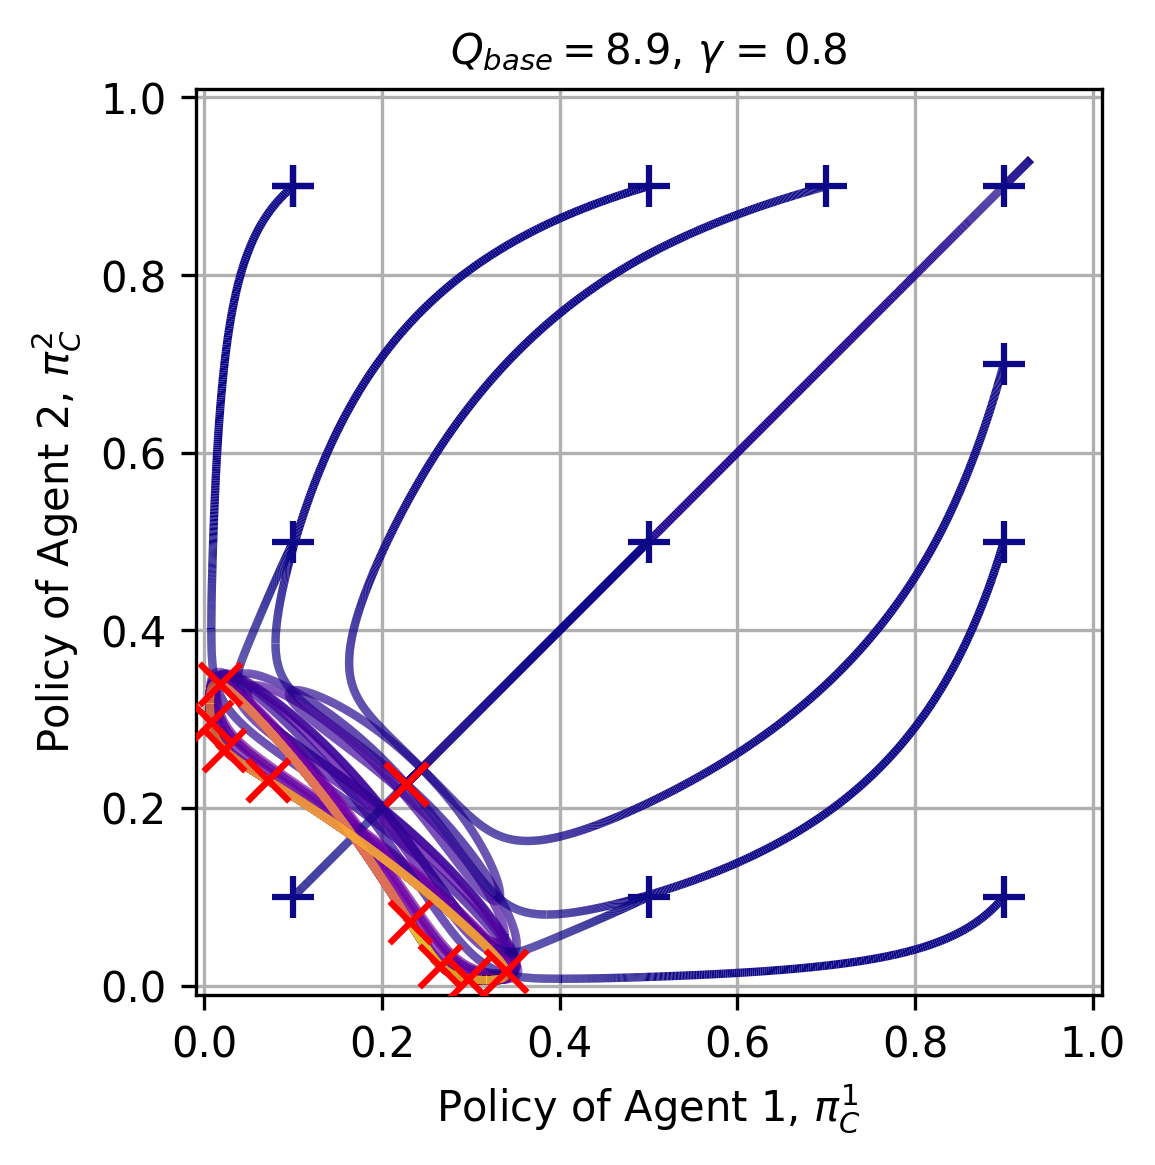

In [3]:
# enable inline plotting
%matplotlib inline
figsize = (4, 4)
dpi = 300
plot_colorbar = False

reward_function = reward_matrix_for_two_player_PD
reward_matrices, game_title, first_action_title = get_individual_matrices(reward_function)

# Define the parameters
learning_rate = 0.01
discount_factor = 0.8
temperature = 1

# calculate the fixed point policy, the target Q-values and eigenvalues and eigenvectors
fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor)
eigenvalues, eigenvectors = calculate_eigenvalues_and_eigenvectors(discount_factor, temperature, learning_rate, print_solution = False)

# Define base value around which the Q-values are centered if given initial probabilities
base_value = Q_target_C + (Q_target_D - Q_target_C)/2  #0 * 1/(1-discount_factor)
num_time_steps = int(3e4)

# generate initial probability pairs for the complete 1x1 square in policy space
if False: # use this for symmetric initial probability pairs
    #x = np.array([0.9])
    #initial_probability_pairs = [(x[i], x[j]) for i in range(len(x)) for j in range(len(x))]
    initial_probability_pairs = [(0.9, 0.9)]
else: # use this for specific initial probability pairs
    initial_probability_pairs = [(0.1, 0.9), (0.5, 0.9), (0.7,0.9), (0.9, 0.9), (0.9,0.7),
                        (0.1, 0.5), (0.5, 0.5), (0.9, 0.5),
                        (0.1, 0.1), (0.5, 0.1), (0.9, 0.1)]

# Plot the dynamics in policy space
fig = plt.figure(figsize=figsize, dpi=dpi)
plot_time_evolution = True
label_flag_added = False # Flag to add labels only once
marker_size = 100
color_start_scatter = plt.cm.plasma(0.0) # dark purple
color_end_scatter = 'red' #plt.cm.plasma(1.0) # bright yellow

# store outcomes in lists
delta_Q_history_agent_0_list = []
delta_Q_history_agent_1_list = []
sum_Q_history_list = []
diff_deltaQ_agent0_deltaQ_agent1_list = []
diff_Q_agent0_agent1_list = []
# loop over all initial probability pairs
for i, initial_probability_pair in enumerate(initial_probability_pairs):
    # generate the initial Q-values for the agents from the initial probabilities centered around the base value
    Q_values_initial_list = [generate_q_values(probability, temperature, base_value) for probability in initial_probability_pair]

    # define the agents
    agents = [DeterministicAgent(Q_values_initial, learning_rate, discount_factor, temperature) for Q_values_initial in Q_values_initial_list]
    
    # run deterministic Q-learning model
    for time_step in range(num_time_steps):
        Q_step(agents, reward_matrices)
        # print out the progress
        #if time_step % int(num_time_steps/10) == 0:
            #print(f"Progress: {time_step/num_time_steps * 100:.0f}%")
    print("Run finished for initial probability pair", initial_probability_pair, f"Progress: {i+1}/{len(initial_probability_pairs)}")

    # extract relevant information of 4D dynamics in order to plot in lower dimensions
    delta_Q_history_agent_0 = np.array([Q_values[0] - Q_values[1] for Q_values in agents[0].Q_values_history])
    delta_Q_history_agent_1 = np.array([Q_values[0] - Q_values[1] for Q_values in agents[1].Q_values_history])
    sum_Q_history = np.array([np.sum(Q_values) for Q_values in agents[0].Q_values_history]) + np.array([np.sum(Q_values) for Q_values in agents[1].Q_values_history])
    diff_deltaQ_agent0_deltaQ_agent1 = delta_Q_history_agent_0 - delta_Q_history_agent_1
    diff_Q_agent0_agent1 = np.array([np.sum(Q_values) for Q_values in agents[0].Q_values_history]) - np.array([np.sum(Q_values) for Q_values in agents[1].Q_values_history]) # difference between the sum of Q-values of both agents

    # store outcomes in lists
    delta_Q_history_agent_0_list.append(delta_Q_history_agent_0)
    delta_Q_history_agent_1_list.append(delta_Q_history_agent_1)
    sum_Q_history_list.append(sum_Q_history)
    diff_deltaQ_agent0_deltaQ_agent1_list.append(diff_deltaQ_agent0_deltaQ_agent1)
    diff_Q_agent0_agent1_list.append(diff_Q_agent0_agent1)

    # plot only every n-th time step to reduce the number of lines
    n = 1
    
    # get the histories of probabilities to cooperate for each agent 
    prob_coop_of_agent_1_list = [vector[0] for vector in agents[0].prob_vector_history[::n]]
    prob_coop_of_agent_2_list = [vector[0] for vector in agents[1].prob_vector_history[::n]]

    # combine for each time steps the probabilities of both agents so that we can plot in the 1x1 square of policy space
    prob_coop_list = np.array([prob_coop_of_agent_1_list, prob_coop_of_agent_2_list]).T

    if plot_time_evolution:
        #print("len prob_coop_list", len(prob_coop_list))
        # Create a list of lines to plot the time evolution of the trajectories with a color gradient
        lines = [ [prob_coop_list[i], prob_coop_list[i+1]] for i in range(len(prob_coop_list)-1)]
        # Create a LineCollection
        lc = LineCollection(lines, cmap='plasma', linewidths=2, alpha=1)
        # Set the colors of the lines
        lc.set_array(np.linspace(0, 1, len(prob_coop_list)))
        # Add the LineCollection to the plot
        plt.gca().add_collection(lc)

        # Add a colorbar for the time evolution ONLY ONCE
        if i == 0 and plot_colorbar:
            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps')
            # lc is normalized so we need to set the ticks manually
            tick_values = [0, 1]
            tick_labels = [0, num_time_steps]
            cbar.set_ticks(tick_values)  # Set the ticks to the desired positions
            # Format tick labels into scientific notation manually
            cbar.set_ticklabels(["{:.0e}".format(tick_label) for tick_label in tick_labels])
    else:
        # plot dynamics in policy-space in the 1x1 square
        plt.plot(prob_coop_list[:, 0], prob_coop_list[:, 1], alpha = 1)
    plt.scatter(prob_coop_list[0, 0], prob_coop_list[0, 1], marker='+', color=color_start_scatter, zorder=10, s=marker_size)
    plt.scatter(prob_coop_list[-1, 0], prob_coop_list[-1, 1], marker='x', color=color_end_scatter, zorder=10, s=marker_size)
    # add labels only once
    if not label_flag_added:
        plt.scatter(prob_coop_list[0, 0], prob_coop_list[0, 1], marker='+', color=color_start_scatter, label='Start', s=marker_size)
        plt.scatter(prob_coop_list[-1, 0], prob_coop_list[-1, 1], marker='x', color=color_end_scatter, label='End', s=marker_size)
        label_flag_added = True

# add cosmetics to the plot
fontsize = None#12
Figure_format_for_publication = True
if True:
    #plt.title(f'Projection of New Deterministic QL Dynamics (4D)\n to Policy space (2D).', fontsize=fontsize+2)
    if plot_time_evolution:
        if Figure_format_for_publication:
            title = (r'$Q_{base} =$' + f'{base_value:.1f}, '+f'$\\gamma$ = {discount_factor}')
            plt.title(title, wrap=True, horizontalalignment='center', fontsize=fontsize)
        else:
            caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}\n'
                    f'Q-values are initialised around {base_value:.2f}.')
            plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
    else:
        caption = (f'$\\alpha$ = {learning_rate}, T = {temperature}, $\\gamma$ = {discount_factor}\n'
                    f'Q-values are initialised around {base_value:.2f}.'
                    f'\nTrajectories span {num_time_steps:.0e} time steps.\n'
                )
        plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
    # plt.xlabel(f'Agent 1: Prob. of {first_action_title[0]}, $\pi^1_{first_action_title[0]}$', fontsize=fontsize)
    # plt.ylabel(f'Agent 2: Prob. of {first_action_title[0]}, $\pi^2_{first_action_title[0]}$', fontsize=fontsize)
    plt.xlabel(f'Policy of Agent 1, $\pi^1_{first_action_title[0]}$', fontsize=fontsize)
    plt.ylabel(f'Policy of Agent 2, $\pi^2_{first_action_title[0]}$', fontsize=fontsize)
    # set ticks of label to fontsize
    ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
    plt.xticks(ticks=ticks, fontsize=fontsize)
    plt.yticks(ticks=ticks, fontsize=fontsize)
    # fix x and y axis to unit square
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.grid()
    #plt.legend(loc='best', fontsize=fontsize)
    # Ensure the axes are symmetrically scaled
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

# save figure
if True:
    plt.savefig(f'Figures/PaperFigures/Fig5_PD_DeterministicDynamics_discount_{discount_factor}_Qbase_{base_value:.2f}_temp_{temperature}_learningRate_{learning_rate}_numTimeSteps_{num_time_steps}.jpg', dpi=300, bbox_inches='tight')
plt.show()

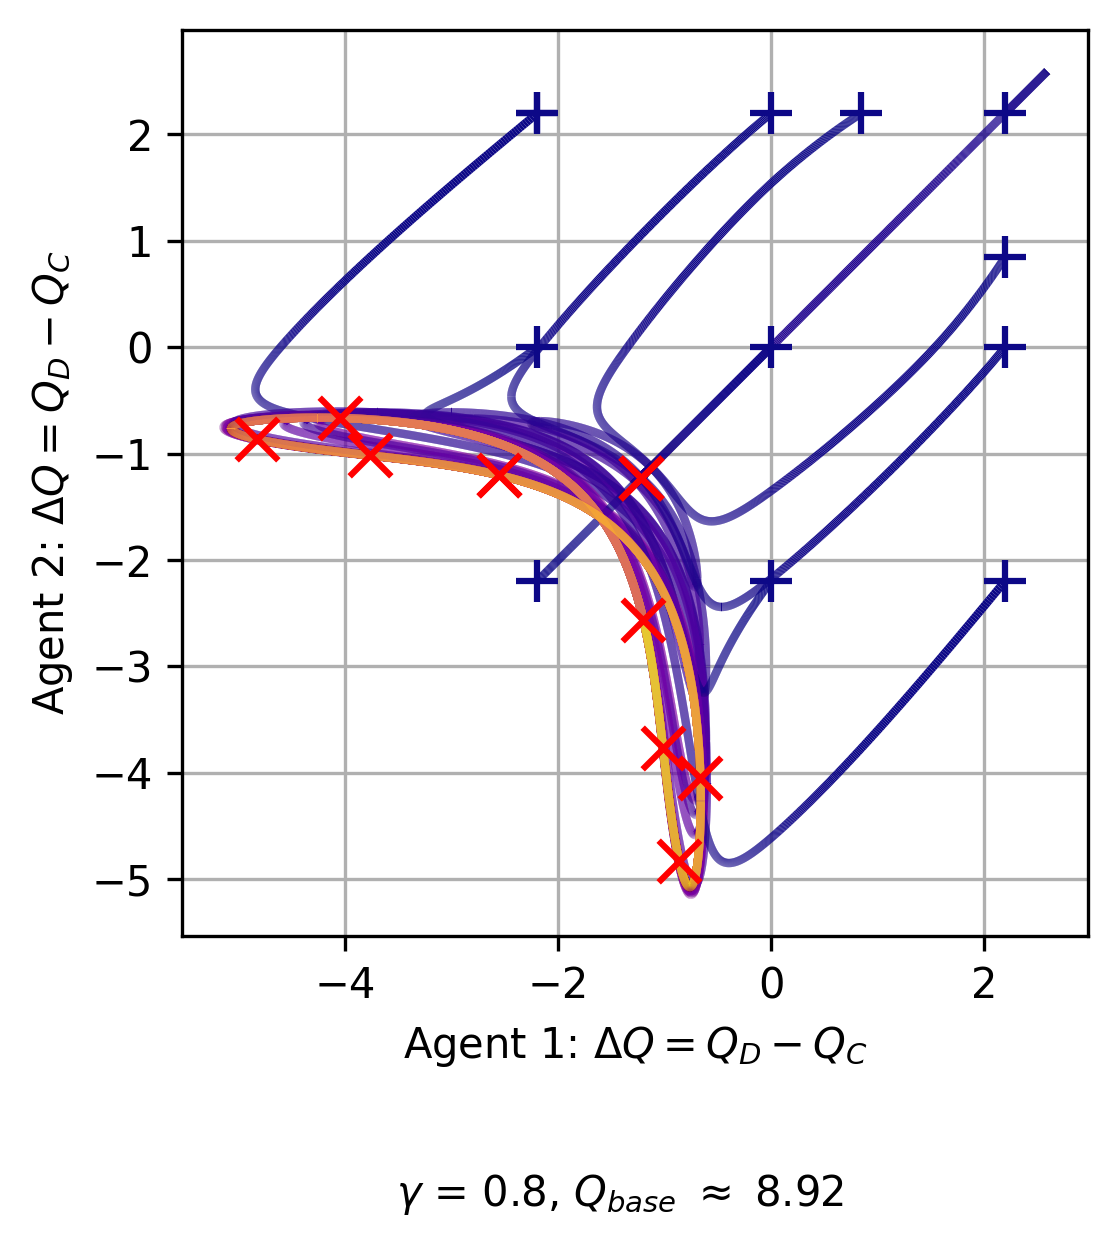

In [4]:
# Enable inline plotting
%matplotlib inline

# plot the first two axis in 2D
plot_time_evolution = True
fig = plt.figure(figsize=figsize, dpi=dpi)
marker_size = 100
for i, initial_probability_pair in enumerate(initial_probability_pairs):
    # plot the first two axis in 2D
    if plot_time_evolution:
        # Create a list of lines to plot the time evolution of the trajectories with a color gradient
        lines = [ [(delta_Q_history_agent_0_list[i][j], delta_Q_history_agent_1_list[i][j]) , (delta_Q_history_agent_0_list[i][j+1], delta_Q_history_agent_1_list[i][j+1])] for j in range(len(delta_Q_history_agent_0_list[i])-1) ]
        # Create a LineCollection
        lc = LineCollection(lines, cmap='plasma', linewidths=2)
        # Set the colors of the lines
        lc.set_array(np.linspace(0, 1, num_time_steps))
        # Add the LineCollection to the plot
        plt.gca().add_collection(lc)

        # Add a colorbar for the time evolution ONLY ONCE
        if i == 0 and plot_colorbar:
            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps')
            # lc is normalized so we need to set the ticks manually
            tick_values = [0, 1]
            tick_labels = [0, num_time_steps]
            cbar.set_ticks(tick_values)  # Set the ticks to the desired positions
            # Format tick labels into scientific notation manually
            cbar.set_ticklabels(["{:.0e}".format(tick_label) for tick_label in tick_labels])
    else:
        plt.plot(delta_Q_history_agent_0_list[i], delta_Q_history_agent_1_list[i], label=f'{initial_probability_pair}')
    # plot the initial and final points
    plt.scatter(delta_Q_history_agent_0_list[i][0], delta_Q_history_agent_1_list[i][0], marker='+', color=color_start_scatter, s=marker_size, zorder=10)
    plt.scatter(delta_Q_history_agent_0_list[i][-1], delta_Q_history_agent_1_list[i][-1], marker='x', color=color_end_scatter, s=marker_size, zorder=10)
    # add labels only once
    if i == 0:
        plt.scatter(delta_Q_history_agent_0_list[i][0], delta_Q_history_agent_1_list[i][0], marker='+', color=color_start_scatter, label='initial', s=marker_size)
        plt.scatter(delta_Q_history_agent_0_list[i][-1], delta_Q_history_agent_1_list[i][-1], marker='x', color=color_end_scatter, label='final', s=marker_size)

#plt.title(f'Projection of Deterministic QL Dynamics (4D)\nto 2D space of $\Delta$Q-values.', fontsize=fontsize+2)
caption = (f'$\\gamma$ = {discount_factor}, ' + r'$Q_{base}$' + f' $\\approx$ {base_value:.2f}'
        )
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=fontsize)
plt.xlabel(f'Agent 1: $\Delta Q = Q_D - Q_C$', fontsize=fontsize)
plt.ylabel(f'Agent 2: $\Delta Q = Q_D - Q_C$', fontsize=fontsize)
# set ticks of label to fontsize
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
# ensure the axes are symmetrically scaled
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
# print legend outside of the plot so that it does not overlap with the plot
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

x_min: -5.105940911700122, x_max: -0.6607452235853151, y_min: -5.105940911700122, y_max: -0.6607452235853151, z_min: -7.732704451282455, z_max: 7.732704451282455


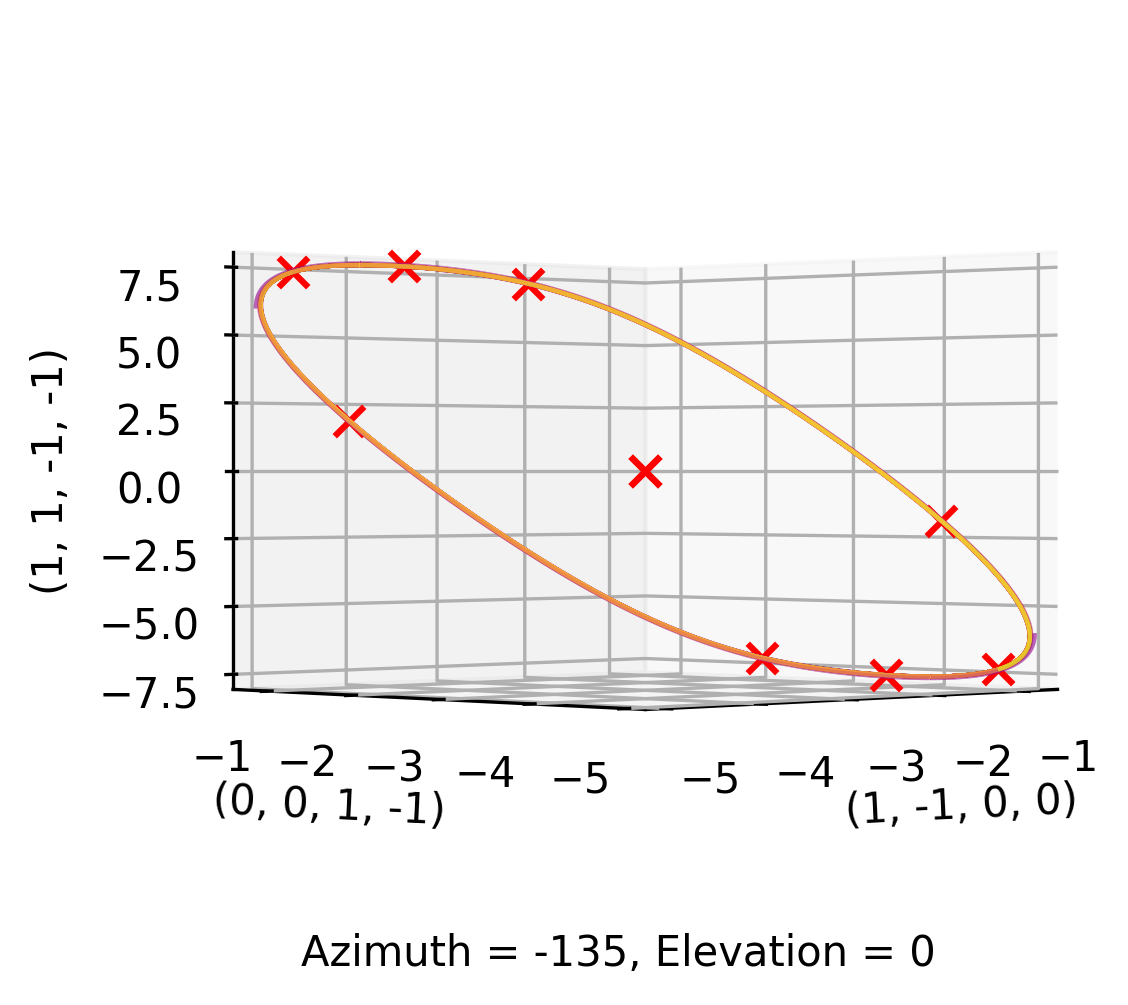

In [6]:
# Enable interactive plotting for 3D plot
%matplotlib inline

# plot the dynamics in a 3D plot.
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111, projection='3d')

# loop over all initial probability pairs
percentage_to_plot = 0.66
plot_time_evolution = True
skip_0909_trajectory = False
print_info = False
for i, initial_probability_pair in enumerate(initial_probability_pairs):
    if print_info:
        print(f"Initial prob {initial_probability_pair}, final values: " 
              f"Delta Q1 {delta_Q_history_agent_0_list[i][-1]:.3f}, " 
              f"Delta Q2 {delta_Q_history_agent_1_list[i][-1]:.3f}, "
              f"Sum Q {sum_Q_history_list[i][-1]:.3f}, "
              f"Diff Delta Q {diff_deltaQ_agent0_deltaQ_agent1_list[i][-1]:.3f}, "
              f"Diff Sum Q {diff_Q_agent0_agent1_list[i][-1]:.3f}"
                          )
    if skip_0909_trajectory and initial_probability_pair == (0.9, 0.9):
        print(f"Skipped trajectory with initial probability pair {initial_probability_pair}")
        continue

    # take only the last % of the data points to plot
    num_time_steps_to_plot = int(percentage_to_plot * num_time_steps)

    # get the data for the 3D plot from the lists
    delta_Q_history_agent_0 = delta_Q_history_agent_0_list[i][-num_time_steps_to_plot:]
    delta_Q_history_agent_1 = delta_Q_history_agent_1_list[i][-num_time_steps_to_plot:]
    sum_Q_agent0_agent1 = sum_Q_history_list[i][-num_time_steps_to_plot:]
    diff_Q_agent0_agent1 = diff_Q_agent0_agent1_list[i][-num_time_steps_to_plot:]
    diff_deltaQ_agent0_deltaQ_agent1 = diff_deltaQ_agent0_deltaQ_agent1_list[i][-num_time_steps_to_plot:]
    # Define a dictionary mapping variables to their names
    axis_label_names = {
        '(1, -1, 0, 0)': delta_Q_history_agent_0,
        '(0, 0, 1, -1)': delta_Q_history_agent_1,
        'Sum of Q values': sum_Q_agent0_agent1,
        '(1, -1, 1, -1)': diff_deltaQ_agent0_deltaQ_agent1,
        '(1, 1, -1, -1)': diff_Q_agent0_agent1
    }

    # choose axes for the 3D plot
    x = delta_Q_history_agent_0
    y = delta_Q_history_agent_1
    z = diff_Q_agent0_agent1
    
    if plot_time_evolution:
        # Create a list of lines to plot the time evolution of the trajectories with a color gradient
        resolution = 1
        lines = [ [(x[j], y[j], z[j]) , (x[j+resolution], y[j+resolution], z[j+resolution])] for j in range(len(x)-resolution) ]
        # create a custom colormap that displays plasma from 1 - percentage_to_plot to 1
        colors = plt.cm.plasma(np.linspace(1 - percentage_to_plot, 1, 256))
        custom_plasma = LinearSegmentedColormap.from_list('custom_plasma', colors)

        # Create a Line3DCollection
        lc = Line3DCollection(lines, cmap=custom_plasma, linewidths=1, alpha=1, zorder=2)
        # Set the colors of the lines
        lc.set_array(np.linspace(0, 1, num_time_steps_to_plot-1))
        # Add the LineCollection to the plot
        ax.add_collection3d(lc)

        # Add a colorbar for the time evolution ONLY ONCE
        if i == 0 and plot_colorbar:
            # start the colorbar at 1 - percentage_to_plot to get the color of the first time step right. The end should be 1, but the start is not 0, but 1 - percentage_to_plot

            cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
            cbar.set_label('time steps')
            # lc is normalized so we need to set the ticks manually
            if percentage_to_plot != percentage_to_plot:
                tick_values = [np.round(1-percentage_to_plot, 2), 1]
            else:
                tick_values = [0, 1]
            tick_labels = [(num_time_steps - num_time_steps_to_plot), num_time_steps]
            cbar.set_ticks(tick_values)
            # Format tick labels into scientific notation manually
            cbar.set_ticklabels(["{:.0e}".format(tick_label) for tick_label in tick_labels])
    else:
        ax.plot(x, y, z)
        
    # plot the initial and final points
    marker_size = 50
    if percentage_to_plot == 1:
        ax.scatter(x[0], y[0], z[0], marker='+', color=plt.cm.plasma(1 - percentage_to_plot), s = marker_size, zorder=1)
    ax.scatter(x[-1], y[-1], z[-1], marker='x', color=color_end_scatter, s = marker_size, zorder=100)

    # plot scatter of fixed points

# add cosmetics to the plot
if True:
    ax.set_xlabel([name for name, values in axis_label_names.items() if values is x][0])
    ax.set_ylabel([name for name, values in axis_label_names.items() if values is y][0])
    ax.set_zlabel([name for name, values in axis_label_names.items() if values is z][0])
    #ax.legend()
    # set axis to min and max values of all trajectories
    # if skip_0909_trajectory is True, the min and max values are calculated without the 0909 trajectory
    if skip_0909_trajectory:
        delta_Q_history_agent_0_list_filtered = [delta_Q_history_agent_0_list[i] for i in range(len(initial_probability_pairs)) if initial_probability_pairs[i] != (0.9, 0.9)]
        delta_Q_history_agent_1_list_filtered = [delta_Q_history_agent_1_list[i] for i in range(len(initial_probability_pairs)) if initial_probability_pairs[i] != (0.9, 0.9)]
        diff_Q_agent0_agent1_list_filtered = [diff_Q_agent0_agent1_list[i] for i in range(len(initial_probability_pairs)) if initial_probability_pairs[i] != (0.9, 0.9)]
        x_min, x_max = min([min(x[-num_time_steps_to_plot:]) for x in delta_Q_history_agent_0_list_filtered]), max([max(x[-num_time_steps_to_plot:]) for x in delta_Q_history_agent_0_list_filtered]) 
        y_min, y_max = min([min(y[-num_time_steps_to_plot:]) for y in delta_Q_history_agent_1_list_filtered]), max([max(y[-num_time_steps_to_plot:]) for y in delta_Q_history_agent_1_list_filtered])
        z_min, z_max = min([min(z[-num_time_steps_to_plot:]) for z in diff_Q_agent0_agent1_list_filtered]), max([max(z[-num_time_steps_to_plot:]) for z in diff_Q_agent0_agent1_list_filtered])
    else:
        x_min, x_max = min([min(x[-num_time_steps_to_plot:]) for x in delta_Q_history_agent_0_list]), max([max(x[-num_time_steps_to_plot:]) for x in delta_Q_history_agent_0_list]) 
        y_min, y_max = min([min(y[-num_time_steps_to_plot:]) for y in delta_Q_history_agent_1_list]), max([max(y[-num_time_steps_to_plot:]) for y in delta_Q_history_agent_1_list])
        z_min, z_max = min([min(z[-num_time_steps_to_plot:]) for z in diff_Q_agent0_agent1_list]), max([max(z[-num_time_steps_to_plot:]) for z in diff_Q_agent0_agent1_list])
    print(f"x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}, z_min: {z_min}, z_max: {z_max}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
# adjust the angle of the plot
azim, elev = -135, 0#45
ax.view_init(elev=elev, azim=azim)
# add caption to the plot
#if plot_time_evolution:
caption = (f'Azimuth = {azim}, Elevation = {elev}') #$\\gamma$ = {discount_factor}, '+r'$Q_{base}$' +f' $\\approx$ {base_value:.1f}\n
if azim == -135 and elev == 0:
    plt.figtext(0.5, 0.1, caption, wrap=True, horizontalalignment='center')
else:
    plt.figtext(0.5, 0.0, caption, wrap=True, horizontalalignment='center')
save_path = f"Figures/PaperFigures/Fig5_3D_plot_azi_{azim}_elev_{elev}_percentage_{percentage_to_plot}_{game_title}_alpha_{learning_rate}_T_{temperature}_gamma_{discount_factor}.jpg"
plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
plt.show()